In [96]:
pip install numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install scikit-surprise==1.1.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [98]:
# Import necessary libraries
import numpy as np
import pandas as pd

Load the dataset and add the decade column by performing a join operation.

In [99]:
# Define the path to your local dataset directory
dataset_path = "../data/ml-100k"

# Load ratings data (assumes the file is 'u.data' in the ml-100k folder)
df_ratings = pd.read_csv(f"{dataset_path}/u.data", sep='\t', header=None, 
                         names=['user_id', 'item_id', 'rating', 'timestamp'])

# Convert item_id to integer
df_ratings['item_id'] = df_ratings['item_id'].astype(int)

# Define movie metadata columns based on u.item structure
movie_columns = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Load movie metadata from local u.item file
df_movies = pd.read_csv(f"{dataset_path}/u.item", sep='|', encoding='latin-1',
                        names=movie_columns, usecols=['item_id', 'release_date'])

# Convert item_id in df_movies to int
df_movies['item_id'] = df_movies['item_id'].astype(int)

# Merge ratings with movie release dates
df_final = pd.merge(df_ratings, df_movies, on='item_id', how='left')

# Drop timestamp as it's not needed
df_final.drop(columns=['timestamp'], inplace=True)

# Convert release_date to datetime, handling missing values
df_final['release_date'] = pd.to_datetime(df_final['release_date'], errors='coerce')

# Extract the year from release_date
df_final['year'] = df_final['release_date'].dt.year

# Create a new column 'decade' by rounding down the year to the nearest decade
df_final['decade'] = (df_final['year'] // 10) * 10

# Drop the 'year' and 'release_date' columns as they're no longer needed
df_final.drop(columns=['year', 'release_date'], inplace=True)

# Display the first few rows of the final DataFrame
print(df_final.head())


   user_id  item_id  rating  decade
0      196      242       3  1990.0
1      186      302       3  1990.0
2       22      377       1  1990.0
3      244       51       2  1990.0
4      166      346       1  1990.0


In [100]:
# Save the df_final dataset as a CSV file in the current directory
df_final.to_csv("../preprocessing/df_final.csv", index=False)

In [103]:
df = df_final 
# Select 10 random unique users from the dataset
random_users = np.random.choice(df['user_id'].unique(), 200, replace=False)

# Count how many movies each user watched
user_movie_counts = df[df['user_id'].isin(random_users)].groupby('user_id')['item_id'].count()

# Convert to DataFrame for better display
df_user_movie_counts = user_movie_counts.reset_index()
df_user_movie_counts.columns = ['user_id', 'movies_watched']

# Display the result
print("Random Users Movie Count:")
print(df_user_movie_counts.max())

Random Users Movie Count:
user_id           943
movies_watched    636
dtype: int64


In [104]:
df = df_final  # Assuming df_final is the DataFrame you're working with

# Count how many movies each user watched in the entire dataset
user_movie_counts_all = df.groupby('user_id')['item_id'].count()

# Get the maximum count of movies rated by any user in the entire dataset
max_movie_count_all = user_movie_counts_all.max()
min_movie_count_all = user_movie_counts_all.min()
print("Maximum number of movies watched by any user in the entire dataset:", max_movie_count_all)
print("Minimum number of movies watched by any user in the entire dataset:", min_movie_count_all)


Maximum number of movies watched by any user in the entire dataset: 737
Minimum number of movies watched by any user in the entire dataset: 20


Counting Movies Per Decade

In [105]:
# Extract unique decades
unique_decades = df_final['decade'].dropna().unique()

# Extract unique item_ids and count total movies
existing_item_ids = df_final['item_id'].unique()
total_movies = df_final['item_id'].nunique()

# Extract the last user ID in df_final and define a starting point for new users
max_existing_user_id = df_final['user_id'].max()
#min_existing_user_id = df_final['user_id'].min()
num_new_users = 40
new_user_start_id = max_existing_user_id + 1

# Count movies per decade
movies_per_decade = df_final.groupby('decade')['item_id'].nunique().reset_index(name='movie_count')
print("Unique Decades Available:", unique_decades)
print("\nMovies Per Decade:")
print(movies_per_decade)
print("\nTotal Unique Movies Available:", total_movies)
print("Starting User ID for New Users:", new_user_start_id)
print("Columns:", df_final.columns)



Unique Decades Available: [1990. 1960. 1970. 1950. 1980. 1940. 1930. 1920.]

Movies Per Decade:
   decade  movie_count
0  1920.0            2
1  1930.0           29
2  1940.0           45
3  1950.0           54
4  1960.0           43
5  1970.0           53
6  1980.0          107
7  1990.0         1348

Total Unique Movies Available: 1682
Starting User ID for New Users: 944
Columns: Index(['user_id', 'item_id', 'rating', 'decade'], dtype='object')


Aggregate User Ratings by Decade: For each user, count the number of movies they’ve rated in each of the 8 decades. You’ll end up with a 943 x 8 matrix where each row is a user, and each column is a decade.

 Code to compute user-decade diversity and clustering

In [106]:
# Step 1: Count number of ratings per user per decade
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)

# Step 2: Normalize counts so each user's row sums to 1
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)

# Step 3: Rename columns to indicate normalization
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]

# Step 4: Merge raw counts with normalized values
user_decade_merged = pd.concat([user_decade_counts, user_decade_normalized], axis=1).reset_index()

# Step 5: Preview the result
#print(user_decade_merged.head())
user_decade_merged


,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,1920_norm,1930_norm,1940_norm,1950_norm,1960_norm,1970_norm,1980_norm,1990_norm
0,1,0,4,1,3,9,18,44,192,0.0,0.014760,0.003690,0.011070,0.033210,0.066421,0.162362,0.708487
1,2,0,0,0,0,0,2,0,60,0.0,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.967742
2,3,0,0,0,0,0,0,0,54,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,4,0,0,0,0,0,2,1,21,0.0,0.000000,0.000000,0.000000,0.000000,0.083333,0.041667,0.875000
4,5,0,2,3,6,9,20,32,102,0.0,0.011494,0.017241,0.034483,0.051724,0.114943,0.183908,0.586207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0,0,0,0,0,1,0,48,0.0,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.979592
939,940,0,1,0,3,3,8,28,64,0.0,0.009346,0.000000,0.028037,0.028037,0.074766,0.261682,0.598131
940,941,0,0,0,0,0,0,0,22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
941,942,0,3,7,6,9,5,11,38,0.0,0.037975,0.088608,0.075949,0.113924,0.063291,0.139241,0.481013


user segmentation based on rating diversity across movie decades.

In [107]:
from scipy.stats import entropy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Step 1: Get counts of ratings per user per decade
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)

# Step 2: Normalize counts to get distribution (row-wise)
user_decade_dist = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)

# Step 3: Calculate entropy (diversity) for each user
user_entropy = user_decade_dist.apply(lambda x: entropy(x), axis=1).to_frame(name='entropy')
user_entropy.reset_index(inplace=True)

# Step 4: Clustering into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
user_entropy['cluster'] = kmeans.fit_predict(user_entropy[['entropy']])

# Step 5: Optional — sort clusters by average entropy for interpretation
cluster_order = user_entropy.groupby('cluster')['entropy'].mean().sort_values().index
entropy_cluster_map = {old: new for new, old in enumerate(cluster_order)}
user_entropy['cluster'] = user_entropy['cluster'].map(entropy_cluster_map)

# Show sample result
print(user_entropy.head())


   user_id   entropy  cluster
0        1  0.965269        1
1        2  0.142506        0
2        3  0.000000        0
3        4  0.456334        0
4        5  1.263807        2


In [123]:
# First part: user_decade_counts and normalized
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]
user_decade_merged = pd.concat([user_decade_counts, user_decade_normalized], axis=1).reset_index()

# Second part: entropy and clustering
user_decade_dist = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_entropy = user_decade_dist.apply(lambda x: entropy(x), axis=1).to_frame(name='entropy')
user_entropy.reset_index(inplace=True)

kmeans = KMeans(n_clusters=3, random_state=42)
user_entropy['cluster'] = kmeans.fit_predict(user_entropy[['entropy']])

cluster_order = user_entropy.groupby('cluster')['entropy'].mean().sort_values().index
entropy_cluster_map = {old: new for new, old in enumerate(cluster_order)}
user_entropy['cluster'] = user_entropy['cluster'].map(entropy_cluster_map)

# Merge counts (decade values only) with entropy
merged_result = pd.merge(user_decade_counts.reset_index(), user_entropy[['user_id', 'entropy']], on='user_id')
# Add cluster column to the merged result
merged_result_with_cluster = pd.merge(
    merged_result,
    user_entropy[['user_id', 'cluster']],
    on='user_id'
)
merged_result_with_cluster


,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,entropy,cluster
0,1,0,4,1,3,9,18,44,192,0.965269,1
1,2,0,0,0,0,0,2,0,60,0.142506,0
2,3,0,0,0,0,0,0,0,54,0.000000,0
3,4,0,0,0,0,0,2,1,21,0.456334,0
4,5,0,2,3,6,9,20,32,102,1.263807,2
...,...,...,...,...,...,...,...,...,...,...,...
938,939,0,0,0,0,0,1,0,48,0.099623,0
939,940,0,1,0,3,3,8,28,64,1.096217,1
940,941,0,0,0,0,0,0,0,22,0.000000,0
941,942,0,3,7,6,9,5,11,38,1.583434,2


In [ ]:
# First part: user_decade_counts and normalized
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]
user_decade_merged = pd.concat([user_decade_counts, user_decade_normalized], axis=1).reset_index()

# Second part: entropy and clustering
user_decade_dist = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_entropy = user_decade_dist.apply(lambda x: entropy(x), axis=1).to_frame(name='entropy')
user_entropy.reset_index(inplace=True)

kmeans = KMeans(n_clusters=3, random_state=42)
user_entropy['cluster'] = kmeans.fit_predict(user_entropy[['entropy']])

cluster_order = user_entropy.groupby('cluster')['entropy'].mean().sort_values().index
entropy_cluster_map = {old: new for new, old in enumerate(cluster_order)}
user_entropy['cluster'] = user_entropy['cluster'].map(entropy_cluster_map)

# Merge counts (decade values only) with entropy
merged_result = pd.merge(user_decade_counts.reset_index(), user_entropy[['user_id', 'entropy']], on='user_id')
# Add cluster column to the merged result
merged_result_with_cluster = pd.merge(
    merged_result,
    user_entropy[['user_id', 'cluster']],
    on='user_id'
)
merged_result_with_cluster


In [124]:
# Merge counts (decade values only) with entropy
merged_result = pd.merge(user_decade_counts.reset_index(), user_entropy[['user_id', 'entropy']], on='user_id')

# Add cluster column to the merged result
merged_result_with_cluster = pd.merge(
    merged_result,
    user_entropy[['user_id', 'cluster']],
    on='user_id'
)

# Sort by entropy
merged_result_with_cluster = merged_result_with_cluster.sort_values(by='entropy')


In [125]:
merged_result_with_cluster

,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,entropy,cluster
543,544,0,0,0,0,0,0,0,31,0.000000,0
800,801,0,0,0,0,0,0,0,26,0.000000,0
204,205,0,0,0,0,0,0,0,22,0.000000,0
205,206,0,0,0,0,0,0,0,64,0.000000,0
571,572,0,0,0,0,0,0,0,20,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
552,553,0,8,13,20,16,5,14,24,1.849938,2
311,312,1,19,24,33,20,22,36,68,1.858054,2
337,338,0,6,8,9,10,9,11,22,1.859598,2
425,426,0,13,24,23,14,9,8,10,1.861485,2


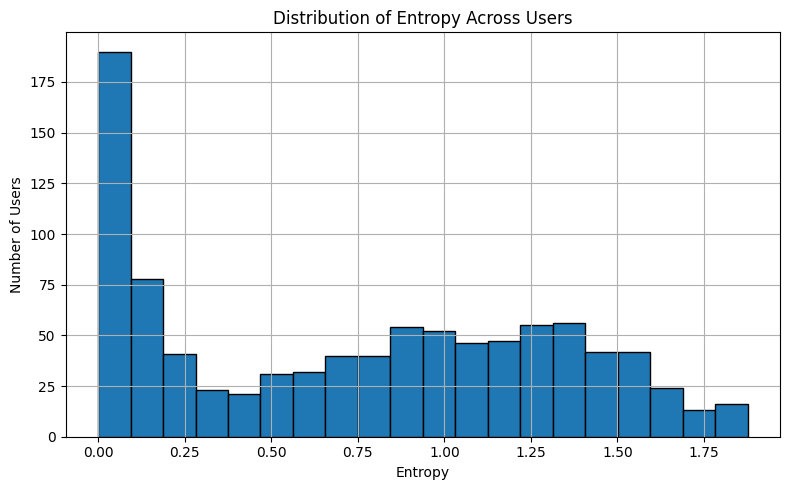

In [126]:
import matplotlib.pyplot as plt

# Plot histogram of entropy values
plt.figure(figsize=(8, 5))
plt.hist(merged_result_with_cluster['entropy'], bins=20, edgecolor='black')
plt.title('Distribution of Entropy Across Users')
plt.xlabel('Entropy')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
merged_result_with_cluster.to_csv("../preprocessing/merged_result_with_cluster.csv", index=False)

In [110]:
user_entropy.to_csv("../preprocessing/user_entropy.csv", index=False)

In [121]:
user_entropy

,user_id,entropy,cluster
0,1,0.965269,1
1,2,0.142506,0
2,3,0.000000,0
3,4,0.456334,0
4,5,1.263807,2
...,...,...,...
938,939,0.099623,0
939,940,1.096217,1
940,941,0.000000,0
941,942,1.583434,2


In [111]:
user_entropy[user_entropy["cluster"] ==0]

,user_id,entropy,cluster
1,2,0.142506,0
2,3,0.000000,0
3,4,0.456334,0
14,15,0.095030,0
16,17,0.154076,0
...,...,...,...
935,936,0.074023,0
936,937,0.116907,0
937,938,0.126931,0
938,939,0.099623,0


In [120]:
# 1. Count of users per cluster
user_counts = user_entropy['cluster'].value_counts().sort_index()
print("Users per cluster:\n", user_counts)

# 2. Get 10 example user_ids per cluster
example_users = user_entropy.groupby('cluster')['user_id'].apply(
    lambda x: x.sample(15, random_state=11)
).reset_index()  # keep the cluster column
print("\n15 example user_ids per cluster:")
for cluster in sorted(example_users['cluster'].unique()):
    users = example_users[example_users['cluster'] == cluster]['user_id'].tolist()
    print(f"Cluster {cluster}: {users}")

Users per cluster:
 cluster
0    353
1    287
2    303
Name: count, dtype: int64

15 example user_ids per cluster:
Cluster 0: [462, 839, 359, 45, 510, 111, 63, 919, 410, 728, 525, 227, 677, 284, 614]
Cluster 1: [430, 758, 727, 457, 606, 174, 886, 268, 219, 684, 605, 665, 11, 323, 87]
Cluster 2: [641, 28, 876, 924, 202, 318, 561, 412, 843, 123, 524, 738, 535, 452, 474]


In [113]:
# # Step 1: Get user_ids from Cluster 0 (low entropy) 
# cluster_0_users = user_entropy[user_entropy['cluster'] == 0]['user_id']
# cluster_1_users = user_entropy[user_entropy['cluster'] == 1]['user_id']
# cluster_2_users = user_entropy[user_entropy['cluster'] == 2]['user_id']

# # Step 2: Filter original df_final for only those users
# cluster_0_ratings = df_final[df_final['user_id'].isin(cluster_0_users)]
# cluster_1_ratings = df_final[df_final['user_id'].isin(cluster_1_users)]
# cluster_2_ratings = df_final[df_final['user_id'].isin(cluster_2_users)]

# # Step 3: Count ratings per user
# ratings_per_user_cluster_0 = cluster_0_ratings.groupby('user_id').size().reset_index(name='num_ratings')
# ratings_per_user_cluster_1 = cluster_1_ratings.groupby('user_id').size().reset_index(name='num_ratings')
# ratings_per_user_cluster_2 = cluster_2_ratings.groupby('user_id').size().reset_index(name='num_ratings')

# # Step 4: Preview the result
# print("\ncluster 0:\n", ratings_per_user_cluster_0.max())
# print("\ncluster 1:\n", ratings_per_user_cluster_1.max())
# print("\ncluster 2:\n", ratings_per_user_cluster_2.max())


In [ ]:
# Group ratings per user by cluster
for cluster_id in range(3):
    users = user_entropy[user_entropy['cluster'] == cluster_id]['user_id']
    ratings = df_final[df_final['user_id'].isin(users)]
    ratings_per_user = ratings.groupby('user_id').size().reset_index(name='num_ratings')
    print(f"\nCluster {cluster_id}:\n", ratings_per_user.max())
    print(f"\nCluster {cluster_id}:\n", ratings_per_user.min())


Cluster 0:
 user_id        941
num_ratings    435
dtype: int64

Cluster 0:
 user_id         2
num_ratings    20
dtype: int64

Cluster 1:
 user_id        943
num_ratings    737
dtype: int64

Cluster 1:
 user_id         1
num_ratings    20
dtype: int64

Cluster 2:
 user_id        942
num_ratings    540
dtype: int64

Cluster 2:
 user_id         5
num_ratings    20
dtype: int64


In [ ]:
# Find the cluster for user_id == 728
user_cluster_728 = user_entropy[user_entropy['user_id'] == 942]['cluster'].values[0]

# Print the result
print(f"User_id 728 belongs to cluster: {user_cluster_728}")

User_id 728 belongs to cluster: 2


In [76]:
# Step 1: Get user clusters
user_clusters = user_entropy[['user_id', 'cluster']]

# Step 2: Count number of ratings per user
user_rating_counts = df_final.groupby('user_id').size().reset_index(name='num_ratings')

# Step 3: Merge counts with cluster labels
user_info = pd.merge(user_clusters, user_rating_counts, on='user_id')

# Step 4: Split into three DataFrames by cluster
cluster_0_df = user_info[user_info['cluster'] == 0][['user_id', 'num_ratings']]
cluster_1_df = user_info[user_info['cluster'] == 1][['user_id', 'num_ratings']]
cluster_2_df = user_info[user_info['cluster'] == 2][['user_id', 'num_ratings']]

# Step 5: Save to CSV
cluster_0_df.to_csv("../preprocessing/cluster_0_users.csv", index=False)
cluster_1_df.to_csv("../preprocessing/cluster_1_users.csv", index=False)
cluster_2_df.to_csv("../preprocessing/cluster_2_users.csv", index=False)

"../cluster_0_users.csv", "../cluster_1_users.csv", "../cluster_2_users.csv"


('../cluster_0_users.csv', '../cluster_1_users.csv', '../cluster_2_users.csv')

Creating biased datasets

In [116]:
def create_new_users_dataset(num_new_users, users_per_decade, start_user_id, df_final):
    # List to store new user data
    new_users_data = []
    
    # Define fixed decades
    decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990]

    # ✅ Loop to create new users
    for i in range(num_new_users):
        user_id = start_user_id + i  # Generate unique user ID
        
        # Handle case when index exceeds available decades
        if i // users_per_decade >= len(decades):
            favorite_decade = decades[-1]  # Assign the last available decade if overflow
        else:
            favorite_decade = decades[i // users_per_decade]  # Assign a favorite decade for the user

        # 🎥 Get all movies from the selected favorite decade
        movies_from_fav_decade = df_final[df_final['decade'] == favorite_decade]['item_id'].unique()

        # 🎯 Assign a rating of 5.0 only for movies in the favorite decade
        for item_id in movies_from_fav_decade:
            new_users_data.append([user_id, item_id, 5.0, favorite_decade])

    # ✅ Convert new users' data into a DataFrame
    df_new_users = pd.DataFrame(new_users_data, columns=['user_id', 'item_id', 'rating', 'decade'])

    # 🔄 Merge the new users' data with the original dataset
    df_merged = pd.concat([df_final, df_new_users], ignore_index=True)

    print(f"✅ New dataset generated for {num_new_users} users with {users_per_decade} users per decade.")
    print(f"🔹 New dataset size: {df_merged.shape}")
    
    return df_merged, df_new_users


In [117]:
# Count initial rows in the original dataset
initial_rows = df_final.shape[0]
print(f"✅ Initial number of rows in the original dataset: {initial_rows}")


✅ Initial number of rows in the original dataset: 100000


In [79]:
# Generate dataset for 40 new users (5 users per decade)
df_40_40, df_new_40 = create_new_users_dataset(40, 5, 944, df_final)

# Generate dataset for 80 new users (10 users per decade)
df_40_80, df_new_80 = create_new_users_dataset(80, 10, 944, df_final)

# Generate dataset for 120 new users (15 users per decade)
df_40_120, df_new_120 = create_new_users_dataset(120, 15, 944, df_final)


✅ New dataset generated for 40 users with 5 users per decade.
🔹 New dataset size: (108405, 4)
✅ New dataset generated for 80 users with 10 users per decade.
🔹 New dataset size: (116810, 4)
✅ New dataset generated for 120 users with 15 users per decade.
🔹 New dataset size: (125215, 4)


In [118]:
def check_validity(df_new_users, num_users):
    # 🔍 Check if any user has been mistakenly assigned more than 1 favorite decade
    favorite_decades_per_user = df_new_users.groupby('user_id')['decade'].nunique()
    multiple_favorite_decades = favorite_decades_per_user[favorite_decades_per_user > 1]

    # ✅ Verify that no user has more than 1 favorite decade
    if multiple_favorite_decades.empty:
        print(f"✅ All {num_users} new users have 1 and only 1 favorite decade.")
    else:
        print(f"❌ These users have more than 1 favorite decade: {multiple_favorite_decades.index.tolist()}")

# Check validity for 40 new users
check_validity(df_new_40, 40)

# Check validity for 80 new users
check_validity(df_new_80, 80)

# Check validity for 120 new users
check_validity(df_new_120, 120)


✅ All 40 new users have 1 and only 1 favorite decade.
✅ All 80 new users have 1 and only 1 favorite decade.
✅ All 120 new users have 1 and only 1 favorite decade.


In [ ]:
# Select the first three columns for each dataset
columns_to_save = ['user_id', 'item_id', 'rating']

# Extract and save the selected columns for each dataset
df_40_40[columns_to_save].to_csv("df_40.csv", index=False)
df_40_80[columns_to_save].to_csv("df_80.csv", index=False)
df_40_120[columns_to_save].to_csv("df_120.csv", index=False)

print("✅ First three columns of each dataset saved successfully!")

✅ First three columns of each dataset saved successfully!


1M